In [1]:
# ─────────────────────────────────────────────
# 0. 라이브러리 & 기본 설정
# ─────────────────────────────────────────────

!pip install -q gdown torchvision

import os, zipfile, pathlib, shutil, math, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00
Device: cuda


In [2]:
# ─────────────────────────────────────────────
# 1. Gradient Reversal Layer
# ─────────────────────────────────────────────
class GRL(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, g):
        return g.neg() * ctx.alpha, None


In [3]:
# ─────────────────────────────────────────────
# 2. 모델 정의 (원본 DANN 구조)
# ─────────────────────────────────────────────
class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extractor (원본: conv 64→50 + BN + Dropout)
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, 5), nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(64, 50, 5), nn.BatchNorm2d(50), nn.Dropout2d(),
            nn.MaxPool2d(2), nn.ReLU()
        )
        # Label classifier
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.ReLU(),
            nn.Linear(100, 10)
        )
        # Domain classifier
        self.domain = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.ReLU(),
            nn.Linear(100, 2)
        )
    def forward(self, x, alpha=1.0):
        feat = self.feature(x).view(-1, 50 * 4 * 4)
        class_out  = self.classifier(feat)
        domain_out = self.domain(GRL.apply(feat, alpha))
        return class_out, domain_out, feat   # feat → t-SNE용

# PlainCNN (도메인 적응 없이 64→50 구조만 동일)
class PlainCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, 5), nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(64, 50, 5), nn.BatchNorm2d(50),
            nn.MaxPool2d(2), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.ReLU(),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        feat = self.feature(x).view(-1, 50 * 4 * 4)
        return self.classifier(feat), feat

In [4]:
# ─────────────────────────────────────────────
# 3. MNIST-M 데이터셋
# ─────────────────────────────────────────────
class MNISTMDataset(Dataset):
    def __init__(self, img_root, label_txt, transform):
        with open(label_txt) as f:
            items = [l.strip().split() for l in f]
        self.paths  = [os.path.join(img_root, p) for p,_ in items]
        self.labels = [int(l) for _,l in items]
        self.transform = transform
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), self.labels[idx]


In [5]:
# ─────────────────────────────────────────────
# 4. 데이터 로더
# ─────────────────────────────────────────────
zip_id   = "1xoGBDOOnTw1E74OpvVAzJQVed5ylv9Da"    # Drive file ID
zip_name = "mnist-m2.zip"

if not os.path.exists(zip_name):
    print("⬇️  Downloading MNIST-M2 …")
    import gdown
    gdown.download(f"https://drive.google.com/uc?id={zip_id}",
                   zip_name, quiet=False)
else:
    print("👉 ZIP already exists:", zip_name)

extract_root = pathlib.Path("dataset/mnist_m")
if not extract_root.exists():
    print("📦 Extracting …")
    extract_root.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_name) as z:
        z.extractall(extract_root)
    print("✅ Extracted to", extract_root.resolve())
else:
    print("👉 Extract directory already exists:", extract_root.resolve())

class MNISTMDataset(Dataset):
    """
    폴더 안 이미지 + 라벨 텍스트(txt) 형태의 MNIST-M용 커스텀 Dataset
    """
    def __init__(self, img_dir, label_txt, transform=None):
        self.img_dir   = pathlib.Path(img_dir)
        self.transform = transform

        with open(label_txt, 'r') as f:
            lines = f.read().strip().splitlines()

        self.samples = [(self.img_dir / line.split()[0],
                         int(line.split()[1])) for line in lines]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

batch = 128

tf_src = transforms.Compose([
    transforms.Grayscale(3),           # MNIST → 3채널
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
tf_tgt = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Source: MNIST (Train) ----------------------------------------------------
src_train  = datasets.MNIST(root="dataset", train=True,
                            download=True, transform=tf_src)
src_loader = DataLoader(src_train, batch_size=batch,
                        shuffle=True, num_workers=0)

# --- Target: MNIST-M (Test) ---------------------------------------------------
tgt_test   = MNISTMDataset(
    "dataset/mnist_m/mnist_m_test",
    "dataset/mnist_m/mnist_m_test_labels.txt",
    tf_tgt)
tgt_loader = DataLoader(tgt_test, batch_size=batch,
                        shuffle=False, num_workers=0)

print(f"Source: {len(src_train)} images | Target: {len(tgt_test)} images")


⬇️  Downloading MNIST-M2 …


Downloading...
From (original): https://drive.google.com/uc?id=1xoGBDOOnTw1E74OpvVAzJQVed5ylv9Da
From (redirected): https://drive.google.com/uc?id=1xoGBDOOnTw1E74OpvVAzJQVed5ylv9Da&confirm=t&uuid=84efab95-a238-4539-abeb-50f9cdf456a2
To: /content/mnist-m2.zip
100%|██████████| 147M/147M [00:02<00:00, 57.2MB/s]


📦 Extracting …
✅ Extracted to /content/dataset/mnist_m


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.46MB/s]

Source: 60000 images | Target: 9001 images


In [6]:
# ─────────────────────────────────────────────
# 5. DANN 학습
# ─────────────────────────────────────────────
dann = DANN().to(device)
loss_cls, loss_dom = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()
opt_dann = optim.Adam(dann.parameters(), lr=1e-3)

epochs_dann, len_src = 1, len(src_loader)
for ep in range(1, epochs_dann+1):
    dann.train(); run=0; tgt_iter=iter(tgt_loader)
    pbar=tqdm(src_loader, desc=f"[DANN] {ep}/{epochs_dann}", leave=False)
    for step,(s_x,s_y) in enumerate(pbar):
        try: t_x,_=next(tgt_iter)
        except StopIteration: tgt_iter=iter(tgt_loader); t_x,_=next(tgt_iter)

        p = float(step+(ep-1)*len_src)/(epochs_dann*len_src)
        alpha = 2/(1+math.exp(-10*p)) - 1

        s_x,s_y = s_x.to(device), s_y.to(device); t_x=t_x.to(device)
        dom_s = torch.zeros(s_x.size(0),dtype=torch.long,device=device)
        dom_t = torch.ones (t_x.size(0),dtype=torch.long,device=device)

        opt_dann.zero_grad()
        c_out, d_out_s,_ = dann(s_x,alpha)
        _,     d_out_t,_ = dann(t_x,alpha)
        loss = (loss_cls(c_out,s_y)
               +loss_dom(d_out_s,dom_s)
               +loss_dom(d_out_t,dom_t))
        loss.backward(); opt_dann.step()
        run += loss.item(); pbar.set_postfix(loss=f"{loss.item():.4f}")

    # epoch-별 MNIST-M 정확도
    dann.eval(); corr=tot=0
    with torch.no_grad():
        for x,y in tgt_loader:
            pred = dann(x.to(device),0)[0].argmax(1).cpu()
            corr += pred.eq(y).sum().item(); tot += y.size(0)
    print(f"📘 DANN Epoch {ep:2d} │ MNIST-M {corr/tot*100:.2f}%")

📘 DANN Epoch  1 │ MNIST-M 64.99%


In [7]:
# ─────────────────────────────────────────────
# 6. PlainCNN 학습
# ─────────────────────────────────────────────
plain = PlainCNN().to(device)
opt_plain = optim.Adam(plain.parameters(), lr=1e-3)
crit_plain= nn.CrossEntropyLoss()

epochs_plain = 1
for ep in range(1,epochs_plain+1):
    plain.train(); run=0
    pbar=tqdm(src_loader, desc=f"[Plain] {ep}/{epochs_plain}", leave=False)
    for x,y in pbar:
        x,y = x.to(device), y.to(device)
        opt_plain.zero_grad()
        out,_ = plain(x)
        loss  = crit_plain(out,y)
        loss.backward(); opt_plain.step()
        run += loss.item(); pbar.set_postfix(loss=f"{loss.item():.4f}")
    # MNIST-M 정확도
    plain.eval(); corr=tot=0
    with torch.no_grad():
        for x,y in tgt_loader:
            pred = plain(x.to(device))[0].argmax(1).cpu()
            corr+=pred.eq(y).sum().item(); tot+=y.size(0)
    print(f"🟢 Plain Epoch {ep:2d} │ MNIST-M {corr/tot*100:.2f}%")


🟢 Plain Epoch  1 │ MNIST-M 26.00%


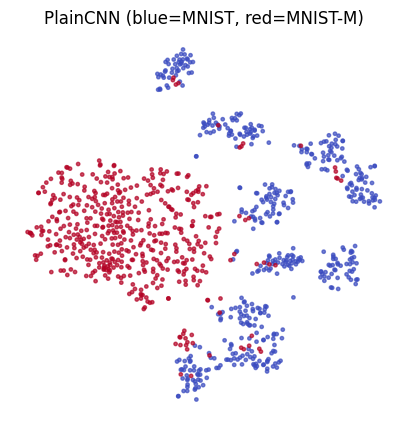

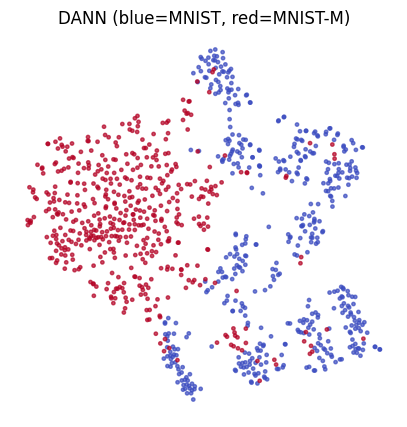

In [8]:
# ─────────────────────────────────────────────
# 7. t-SNE 시각화 (500+500 샘플)
# ─────────────────────────────────────────────
def collect_feat(model, loader, label, n=500):
    feats,dom=[],[]
    model.eval()
    with torch.no_grad():
        for x,_ in loader:
            f = model(x.to(device),0)[2].cpu() if isinstance(model,DANN) else model(x.to(device))[1].cpu()
            feats.append(f); dom += [label]*f.size(0)
            if len(dom)>=n: break
    return torch.cat(feats)[:n], dom[:n]

f_src_p,d_src_p = collect_feat(plain, src_loader, 0)
f_tgt_p,d_tgt_p = collect_feat(plain, tgt_loader, 1)
f_src_d,d_src_d = collect_feat(dann,  src_loader, 0)
f_tgt_d,d_tgt_d = collect_feat(dann,  tgt_loader, 1)

def tsne_plot(feat, dom, title):
    emb = TSNE(n_components=2, init='pca', random_state=0).fit_transform(feat)
    plt.figure(figsize=(5,5))
    plt.scatter(emb[:,0], emb[:,1], c=dom, cmap='coolwarm', s=6, alpha=0.7)
    plt.title(title); plt.axis('off'); plt.show()

tsne_plot(torch.cat([f_src_p,f_tgt_p]), d_src_p+d_tgt_p,
          "PlainCNN (blue=MNIST, red=MNIST-M)")
tsne_plot(torch.cat([f_src_d,f_tgt_d]), d_src_d+d_tgt_d,
          "DANN (blue=MNIST, red=MNIST-M)")

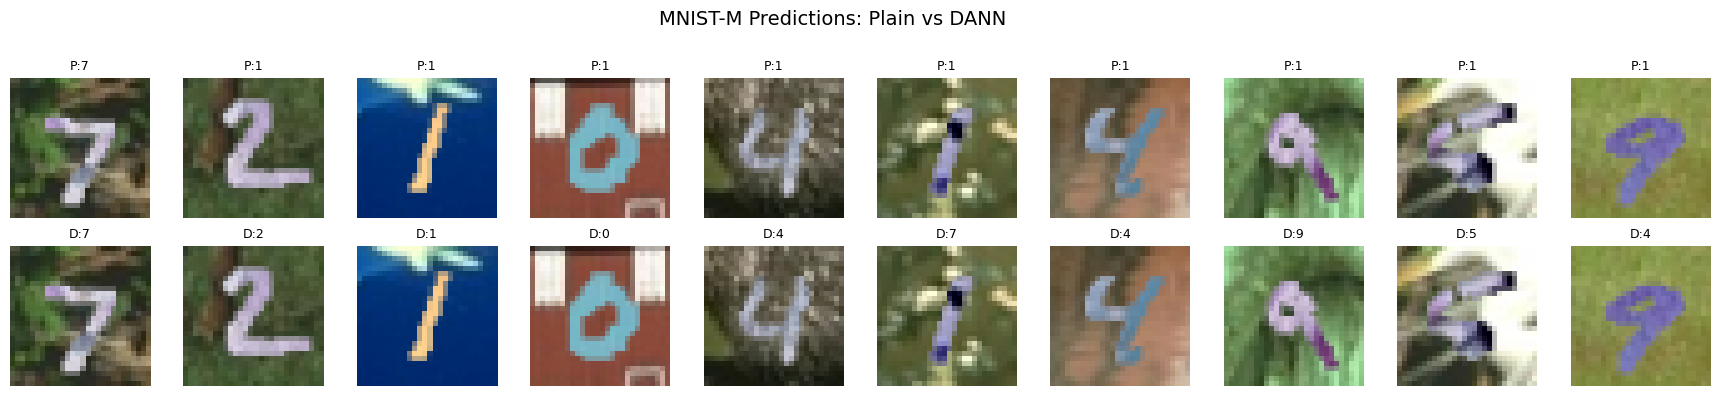

In [9]:
# ─────────────────────────────────────────────
# 8. 샘플 10장 예측 비교
# ─────────────────────────────────────────────
plain.eval(); dann.eval()
imgs,lbls = next(iter(tgt_loader))
imgs,lbls = imgs[:10], lbls[:10]
with torch.no_grad():
    pred_p = plain(imgs.to(device))[0].argmax(1).cpu()
    pred_d = dann(imgs.to(device),0)[0].argmax(1).cpu()

fig,axs = plt.subplots(2,10,figsize=(22,4))
for i in range(10):
    v = (imgs[i].permute(1,2,0)*0.5+0.5).numpy()
    axs[0][i].imshow(v.squeeze(), cmap='gray')
    axs[0][i].set_title(f"P:{pred_p[i]}", fontsize=9)
    axs[1][i].imshow(v.squeeze(), cmap='gray')
    axs[1][i].set_title(f"D:{pred_d[i]}", fontsize=9)
    axs[0][i].axis('off'); axs[1][i].axis('off')
axs[0][0].set_ylabel("Plain", rotation=0, labelpad=25, size=12)
axs[1][0].set_ylabel("DANN",  rotation=0, labelpad=25, size=12)
plt.suptitle("MNIST-M Predictions: Plain vs DANN", y=1.05, fontsize=14)
plt.show()
